<a href="https://colab.research.google.com/github/YouMinJung/Handwriting_ImageSegmentation/blob/main/Handwriting_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation of Handwritten Digits
Build  a model that predicts the segmentation masks of handwritten digits.

I will use multi digit MNIST Dataset. [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist)

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.2


## Download the dataset - M2NIST

In [2]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip \
    -O /tmp/m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2022-07-15 05:00:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.217.13.240, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  --.-KB/s    in 0.1s    

2022-07-15 05:00:24 (172 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



## Load and Preprocess the Dataset

M2NIST Dataset can be preprocessed since it is available as **Numpy Array Files (.npy)**

- **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

- **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has 5000 samples.

In [3]:
def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files 
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

In [4]:
BATCH_SIZE = 32


def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.
  
  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.
  
  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

## Check the Dataset
using visualization Utilites, inspect the dataset.

In [5]:
#### Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

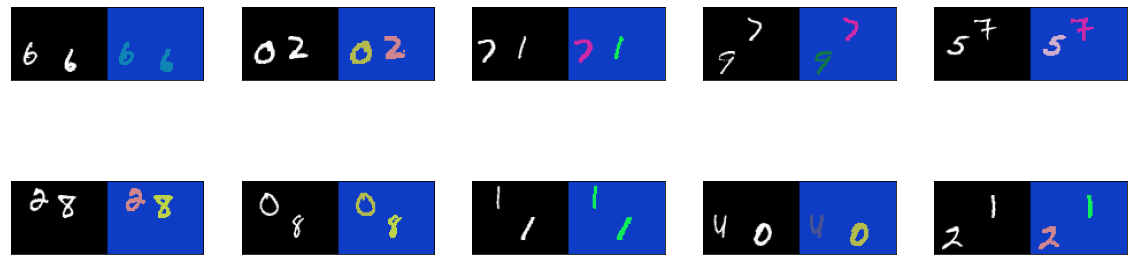

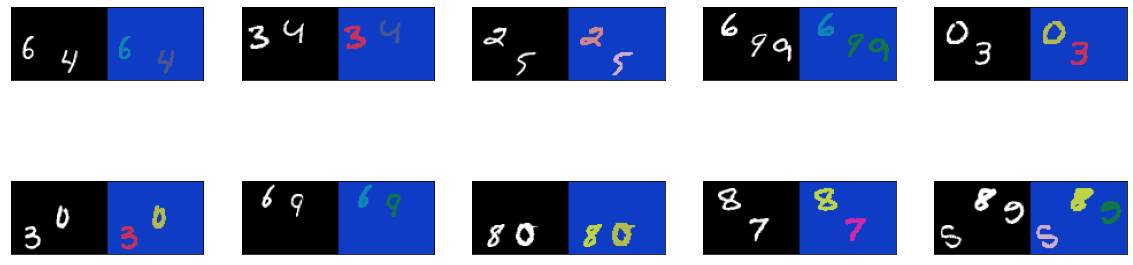

In [6]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

## Define the Model

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

Image segmentation model will have two paths.

- **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features.

- **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. I will use an FCN-8 decoder for this path.

### Define The Basic Convolution Block

Defined the building block of encoder.

Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> maxPooling2D -> BatchNormalization

**Conv2D** : data_format='channels_last' is (batch_size, height, width, channels) 

In [7]:
def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format='channels_last')(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format='channels_last')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pooling_size, pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [8]:
#### TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 84, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 84, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 84, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 42, 32)       0         
 )                                                               
                                                             

### Define The Downsampling Path



In [9]:
def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input) # pad the input image width to 96 pixels
    
    # Block 1
    x = conv_block(x, 32, 2, 2, 2)
    
    # Block 2
    x = conv_block(x, 64, 2, 2, 2)

    # Block 3
    x = conv_block(x, 128, 2, 2, 2)
    f3 = x # save the feature map at this stage

    # Block 4
    x = conv_block(x, 256, 2, 2, 2)
    f4 = x # save the feature map at this stage

    # Block 5
    x = conv_block(x, 256, 2, 2, 2)
    f5 = x # save the feature map at this stage
  
    return (f3, f4, f5), img_input

In [10]:
#### TEST CODE:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 64, 96, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 96, 32)        160       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 96, 32)        4128      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                           

#### Define The Upsampling Path



In [11]:
def fcn8_decoder(convs, n_classes):

  f3, f4, f5 = convs # features from the encoder stage
  n = 512 # number of filters

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n, (7,7), activation='relu' , padding='same', name="conv6", data_format='channels_last')(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n, (1,1), activation='relu' , padding='same', name="conv7", data_format='channels_last')(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu' , padding='same', data_format='channels_last')(o)

  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same')(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes, (1,1) , activation='relu' , padding='same', data_format='channels_last')(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8))(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [12]:
#### TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


### Define The Complete Model
-> downsampling and upsampling paths

In [13]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

## Compile The Model

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1E-2), metrics=['accuracy'])

## Model Training

In [15]:
EPOCHS = 70
steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/70
125/125 [==============================] - 21s 51ms/step - loss: 0.2711 - accuracy: 0.9302 - val_loss: 0.2796 - val_accuracy: 0.9425
Epoch 2/70
125/125 [==============================] - 6s 45ms/step - loss: 0.1564 - accuracy: 0.9469 - val_loss: 0.1649 - val_accuracy: 0.9485
Epoch 3/70
125/125 [==============================] - 6s 45ms/step - loss: 0.1235 - accuracy: 0.9561 - val_loss: 0.1347 - val_accuracy: 0.9577
Epoch 4/70
125/125 [==============================] - 6s 46ms/step - loss: 0.0972 - accuracy: 0.9656 - val_loss: 0.1058 - val_accuracy: 0.9648
Epoch 5/70
125/125 [==============================] - 5s 44ms/step - loss: 0.0755 - accuracy: 0.9723 - val_loss: 0.0841 - val_accuracy: 0.9716
Epoch 6/70
125/125 [==============================] - 5s 44ms/step - loss: 0.0651 - accuracy: 0.9755 - val_loss: 0.0987 - val_accuracy: 0.9665
Epoch 7/70
125/125 [==============================] - 5s 43ms/step - loss: 0.0583 - accuracy: 0.9774 - val_loss: 0.0922 - val_accuracy: 0.967

## Model Evaluation

### Predictions

In [16]:
results = model.predict(test_dataset, steps=test_steps)

# This means that for each of the 192 images that we have in our test set, there are 11 predictions generated (i.e. one for each class: 0 to 1 plus background).
print(results.shape)

(192, 64, 84, 11)


In [17]:
# get the index of the highest probability of each of these 11 slices and combine them in a single image.
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


In [18]:
print(results[0,0,0])

# prediction map for image 0
# The upper left corner is usually just part of the background (class 10). The actual digits are written somewhere in the middle parts of the image.
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### Metrics

There are two ways to evaluate predictions. The intersection over union (IOU)and the dice score.

<br>
$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$
<br>

In [19]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

### Visualize Predictions

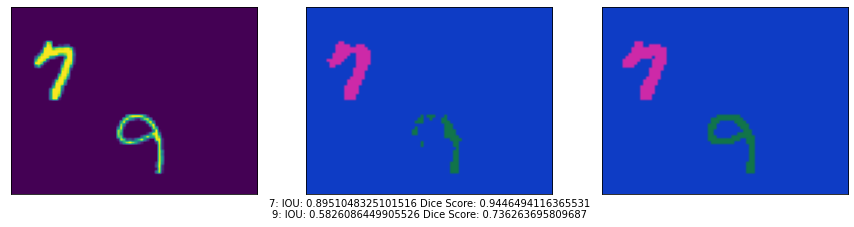

In [20]:
integer_slider = 105 # between 0 to 191 to pick an image from the test set

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)

### Compute IOU Score and Dice Score of the model

In [21]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

print("\nGrade is " + str(average_iou * 10))

Digit 0: IOU: 0.8315009827201701 Dice Score: 0.9079994939289779
Digit 1: IOU: 0.8283220147807241 Dice Score: 0.906100794153668
Digit 2: IOU: 0.8248056981463638 Dice Score: 0.9039929007063062
Digit 3: IOU: 0.7796501351634567 Dice Score: 0.876183604584558
Digit 4: IOU: 0.7712755390373428 Dice Score: 0.8708701972551571
Digit 5: IOU: 0.7705311104537452 Dice Score: 0.8703954490314224
Digit 6: IOU: 0.7759562831434345 Dice Score: 0.8738461532059735
Digit 7: IOU: 0.8333981074836143 Dice Score: 0.9091294510252054
Digit 8: IOU: 0.7754332018230391 Dice Score: 0.8735143637359194
Digit 9: IOU: 0.7531268601055289 Dice Score: 0.8591812460852886

Grade is 79.4399993285742
